In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kaggle --upgrade
!mv .kaggle /root/
!mv /content/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images
!mv '/content/lung-and-colon-cancer-histopathological-images.zip' '/content/drive/MyDrive/Lung and Colon Cancer'

In [46]:
!pip install -U -q tensorflow-addons

In [47]:
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
import os,cv2

In [9]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Lung and Colon Cancer/lung-and-colon-cancer-histopathological-images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Lung and Colon Cancer')

In [15]:
len(os.listdir('/content/drive/MyDrive/Lung and Colon Cancer/lung_colon_image_set/colon_image_sets/colon_aca'))

5000

In [17]:
len(os.listdir('/content/drive/MyDrive/Lung and Colon Cancer/lung_colon_image_set/colon_image_sets/colon_n'))

5000

In [48]:
DATA=[]
for i,folder in enumerate(os.listdir('/content/drive/MyDrive/Lung and Colon Cancer/lung_colon_image_set/colon_image_sets')):
  for image in os.listdir(f'/content/drive/MyDrive/Lung and Colon Cancer/lung_colon_image_set/colon_image_sets/{folder}')[:1500]:
    img=cv2.imread(f'/content/drive/MyDrive/Lung and Colon Cancer/lung_colon_image_set/colon_image_sets/{folder}/{image}')
    img=cv2.resize(img,(128,128))/255.0
    DATA.append((img,i))
DATA=np.array(shuffle(DATA))
Images=np.array([i for i in DATA[:,0]]).reshape((3000,128,128,3))
Labels=DATA[:,1]
x_train, y_train,x_test, y_test = Images[:2400],Labels[:2400],Images[2400:],Labels[2400:]
x_train.shape, y_train.shape,x_test.shape, y_test.shape 

<ipython-input-48-cbb889be98ca>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  DATA=np.array(shuffle(DATA))


((2400, 128, 128, 3), (2400,), (600, 128, 128, 3), (600,))

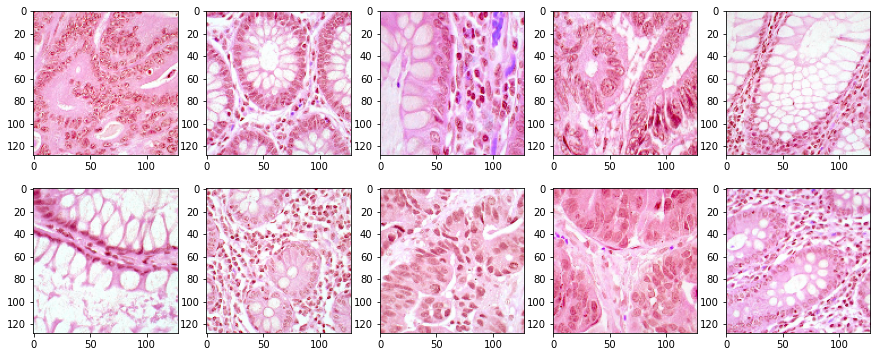

In [49]:
plt.rcParams['figure.figsize']=(15,6)
plt.subplot(2,5,1)
plt.imshow(x_test[0])
plt.subplot(2,5,2)
plt.imshow(x_test[1])
plt.subplot(2,5,3)
plt.imshow(x_test[2])
plt.subplot(2,5,4)
plt.imshow(x_test[3])
plt.subplot(2,5,5)
plt.imshow(x_test[4])

plt.subplot(2,5,6)
plt.imshow(x_test[5])
plt.subplot(2,5,7)
plt.imshow(x_test[6])
plt.subplot(2,5,8)
plt.imshow(x_test[7])
plt.subplot(2,5,9)
plt.imshow(x_test[8])
plt.subplot(2,5,10)
plt.imshow(x_test[9])
plt.show()

In [5]:
y_train=y_train.astype(np.float32)
y_test=y_test.astype(np.float32)

In [23]:
from keras.utils import to_categorical
y_train=to_categorical(y_train,2)
y_test=to_categorical(y_test,2)
y_train.shape

(2400, 2)

In [24]:
val_split = 0.1
val_indices = int(len(x_train) * val_split)
new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]
x_val, y_val = x_train[:val_indices], y_train[:val_indices]

print(f"Training data samples: {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")

Training data samples: 2160
Validation data samples: 240
Test data samples: 600


In [25]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 10

In [26]:
image_size = 128
auto = tf.data.AUTOTUNE

data_augmentation = keras.Sequential(
    [layers.RandomCrop(image_size, image_size), layers.RandomFlip("horizontal"),],
    name="data_augmentation",
)


def make_datasets(images, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x), y), num_parallel_calls=auto
        )
    return dataset.prefetch(auto)


train_dataset = make_datasets(new_x_train, new_y_train, is_train=False)
val_dataset = make_datasets(x_val, y_val)
test_dataset = make_datasets(x_test, y_test)

In [27]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [31]:
def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)


def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)


def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x


def get_conv_mixer_256_8(
    image_size=128, filters=64, depth=8, kernel_size=5, patch_size=2, num_classes=2
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, image_size, 3))
    # Extract patch embeddings.
    x = conv_stem(inputs, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [36]:
# Code reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/.


def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=25,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model

In [39]:
conv_mixer_model = get_conv_mixer_256_8()
history, conv_mixer_model = run_experiment(conv_mixer_model)

Epoch 1/25
68/68 [==============================] - 33s 401ms/step - loss: 0.2243 - accuracy: 0.9259 - val_loss: 1.2018 - val_accuracy: 0.4958
Epoch 2/25
68/68 [==============================] - 26s 377ms/step - loss: 0.0538 - accuracy: 0.9843 - val_loss: 1.8357 - val_accuracy: 0.4958
Epoch 3/25
68/68 [==============================] - 26s 382ms/step - loss: 0.0337 - accuracy: 0.9921 - val_loss: 2.4640 - val_accuracy: 0.4958
Epoch 4/25
68/68 [==============================] - 27s 397ms/step - loss: 0.0244 - accuracy: 0.9921 - val_loss: 2.6931 - val_accuracy: 0.4958
Epoch 5/25
68/68 [==============================] - 27s 399ms/step - loss: 0.0236 - accuracy: 0.9926 - val_loss: 3.1455 - val_accuracy: 0.4958
Epoch 6/25
68/68 [==============================] - 27s 389ms/step - loss: 0.0134 - accuracy: 0.9968 - val_loss: 3.3303 - val_accuracy: 0.4958
Epoch 7/25
68/68 [==============================] - 27s 399ms/step - loss: 0.0105 - accuracy: 0.9972 - val_loss: 1.8670 - val_accuracy: 0.5250

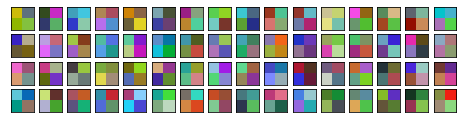

In [42]:
def visualization_plot(weights, idx=1):
    # First, apply min-max normalization to the
    # given weights to avoid isotrophic scaling.
    p_min, p_max = weights.min(), weights.max()
    weights = (weights - p_min) / (p_max - p_min)

    # Visualize all the filters.
    num_filters = 64
    plt.figure(figsize=(8, 8))

    for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        if current_weight.shape[-1] == 1:
            current_weight = current_weight.squeeze()
        ax = plt.subplot(16, 16, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight)
        idx += 1


# We first visualize the learned patch embeddings.
patch_embeddings = conv_mixer_model.layers[1].get_weights()[0]
visualization_plot(patch_embeddings)

In [44]:
conv_mixer_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_63 (Conv2D)             (None, 64, 64, 64)   832         ['input_8[0][0]']                
                                                                                                  
 activation_119 (Activation)    (None, 64, 64, 64)   0           ['conv2d_63[0][0]']              
                                                                                                  
 batch_normalization_119 (Batch  (None, 64, 64, 64)  256         ['activation_119[0][0]']   